**Instructors**: Prof. Keith Chugg (chugg@usc.edu) & Prof. Antonio Ortega (aortega@usc.edu)

**Teaching Assistant**: Alexios Rustom (arustom@usc.edu)

**Book**: Watt, J., Borhani, R., & Katsaggelos, A. K. (2020). Machine learning refined: Foundations, algorithms, and applications. Cambridge University Press.

**Notebooks**: Written by Alexios Rustom (arustom@usc.edu) and Prof. Keith Chugg (chugg@usc.edu) based on the following **Github repository**: [notebooks](https://github.com/jermwatt/machine_learning_refined/tree/gh-pages/presentations/2nd_edition/jupyter%20%2B%20reveal.js%20version)

# Linear Two-Class Classification

In [134]:
import numpy as np
import autograd.numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from autograd import grad 
from autograd import hessian
import math
import copy
import pandas as pd
readDataPath = './readData/'

In [135]:
# compute linear combination of input point
def model_1(x_p,w):
    # compute linear combination and return
    a = w[0] + np.dot(x_p.T,w[1:])
    return a.T

In [136]:
# a least squares function for linear regression
def least_squares(w,x,y):    
    cost = np.sum((model_1(x,w)-y)**2)
    return cost/float(y.size)

In [137]:
## This code cell will not be shown in the HTML version of this notebook
# using an automatic differentiator - like the one imported via the statement below - makes coding up gradient descent a breeze
from autograd import numpy as np
from autograd import value_and_grad 

# gradient descent function - inputs: g (input function), alpha (steplength parameter), max_its (maximum number of iterations), w (initialization)
def gradient_descent(g,alpha_choice,max_its,w, data, labels, inputs_flag = False):
    # compute the gradient function of our input function - note this is a function too
    # that - when evaluated - returns both the gradient and function evaluations (remember
    # as discussed in Chapter 3 we always ge the function evaluation 'for free' when we use
    # an Automatic Differntiator to evaluate the gradient)
    gradient = value_and_grad(g)

    # run the gradient descent loop
    weight_history = []      # container for weight history
    cost_history = []        # container for corresponding cost function history
    alpha = 0
    for k in range(1,max_its+1):
        # check if diminishing steplength rule used
        if alpha_choice == 'diminishing':
            alpha = 1/float(k)
        else:
            alpha = alpha_choice
        
        # evaluate the gradient, store current weights and cost function value
        if (inputs_flag == True):
            cost_eval,grad_eval = gradient(w,data,labels)
        else:
            cost_eval,grad_eval = gradient(w)
            
        weight_history.append(w)
        cost_history.append(cost_eval)

        # take gradient descent step
        w = w - alpha*grad_eval
            
    # collect final weights
    weight_history.append(w)
    # compute final cost function value via g itself (since we aren't computing 
    # the gradient at the final step we don't get the final cost function value 
    # via the Automatic Differentiatoor) 
    if (inputs_flag == True):
        cost_history.append(g(w,data,labels))
    else:
        cost_history.append(g(w))  
    return weight_history,cost_history

In [138]:
# newtons method function - inputs: g (input function), max_its (maximum number of iterations), w (initialization)
def newtons_method(g,max_its,w,data, labels, inputs_flag = False):
    # compute gradient module using autograd
    gradient = grad(g)
    hess = hessian(g)
    
    # set numericxal stability parameter / regularization parameter
    epsilon = 10**(-7)
    #if 'epsilon' in kwargs:
    #    beta = kwargs['epsilon']

    # run the newtons method loop
    weight_history = [w]           # container for weight history
    
    if (inputs_flag == True):
        cost_history = [g(w,x,y)]
    else:
        cost_history = [g(w)] 
        
    for k in range(max_its):
        # evaluate the gradient and hessian
        if (inputs_flag == True):
            grad_eval = gradient(w,data,labels)
            hess_eval = hess(w, data, labels)
        else:
            grad_eval = gradient(w)
            hess_eval = hess(w)

        # reshape hessian to square matrix for numpy linalg functionality
        hess_eval.shape = (int((np.size(hess_eval))**(0.5)),int((np.size(hess_eval))**(0.5)))
        
        # solve second order system system for weight update
        A = hess_eval + epsilon*np.eye(w.size)
        b = grad_eval
        w = np.linalg.solve(A,np.dot(A,w) - b)
        
        # record weight and cost
        weight_history.append(w)
        if (inputs_flag == True):
            cost_history.append(g(w,data,labels))
        else:
            cost_history.append(g(w)) 
    return weight_history,cost_history

In [139]:
def normalized_gradient_descent(g,alpha,max_its,w, data, labels, inputs_flag = True):
    # compute the gradient of our input function - note this is a function too!
    gradient = grad(g)
    weight_history = [w] 
    # run the gradient descent loop
    best_w = w        # weight we return, should be the one providing lowest evaluation
    if (inputs_flag):
        best_eval = g(w,data,labels)       # lowest evaluation yet
    else:
        best_eval = g(w)
    
    for k in range(max_its):
        # evaluate the gradient, compute its length
        if (inputs_flag):
            grad_eval = gradient(w,data,labels)
        else:
            grad_eval = gradient(w)
        grad_norm = np.linalg.norm(grad_eval)
        
        # check that magnitude of gradient is not too small, if yes pick a random direction to move
        if grad_norm == 0:
            # pick random direction and normalize to have unit legnth
            grad_eval = 10**-6*np.sign(2*np.random.rand(len(w)) - 1)
            grad_norm = np.linalg.norm(grad_eval)
            grad_eval /= grad_norm
    
        # take gradient descent step
        w = w - alpha*grad_eval
        
        weight_history.append(w) 
        # return only the weight providing the lowest evaluation
        if (inputs_flag):
            test_eval = g(w,data,labels)
        else:
            test_eval = g(w)
            
        if test_eval < best_eval:
            best_eval = test_eval
            best_w = w
           
    #return best_w.tolist()
    return weight_history

In [140]:
def plot_contours(g, weight_history, title, data, labels, a, b, inputs_flag = False):
    weights_steps_x = np.array([i[0] for i in weight_history])
    weights_steps_y = np.array([i[1] for i in weight_history])
    x = y = np.arange(a, b, 0.1)
    X, Y = np.meshgrid(x, y)
    if (inputs_flag):
        zs = np.array([g(np.array([[x],[y]]), data, labels) for x,y in zip(np.ravel(X), np.ravel(Y))])
    else:
        zs = np.array([g(np.array([x,y])) for x,y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)
    #ax.plot([0, 0], [-4.5,4.5], [0,0])
    fig = plt.figure(figsize=(5,5))
    cp = plt.contourf(X, Y, Z, cmap='coolwarm')
    plt.colorbar(cp)
    plt.xlabel(r'$w_1$', fontsize=12)
    plt.ylabel(r'$w_2$', fontsize=12)
    #plt.axhline(y=0, color='r', linestyle='--')
    #plt.axvline(x=0, color='r', linestyle='--')
    plt.plot(weights_steps_x, weights_steps_y, 'sk', markersize=4)
    plt.quiver(weights_steps_x[:-1], weights_steps_y[:-1], weights_steps_x[1:]-weights_steps_x[:-1], weights_steps_y[1:]-weights_steps_y[:-1], scale_units='xy', angles='xy', scale=1)
    plt.plot(weights_steps_x[-1], weights_steps_y[-1], 'sy')
    plt.title(title,fontsize=16)
    plt.show()

# Logistic Regression

- Two class classification is a particular instance of *regression* or *surface-fitting*.


- Here the output of a dataset of $P$ points $\left\{ \left(\mathbf{x}_{p},y_{p}\right)\right\} _{p=1}^{P}$ is no longer continuous but takes on two fixed numbers.  


- The actual value of these numbers is in principle arbitrary, but particular value pairs are more helpful than others for derivation purposes.


- Here we will use the values $y_{p}\in\left\{ 0,\,+1\right\}$ - that is every output takes on either the value $0$ or $+1$. 

- Often in the context of classification the output values $y_p$ are called *labels*, and all points sharing the same label value are referred to as a *class* of data.  


- Hence a dataset containing points with label values $y_{p}\in\left\{ 0,\,+1\right\}$ is said to be a dataset consisting of two classes.

## Fitting a discontinuous step function

- How can we fit a regression to data that is largely distributed on two adjacent steps separated by a hyperplane?


- Lets look at a simple instance of such a dataset when $N = 1$ to build our intuition about what must be done in general.

- Intuitively it is obvious that simply fitting a line of the form $y = w_0 + w_1x_{\,}$ to such a dataset will result in an extremely subpar results.


- The line by itself is simply too inflexible to account for the nonlinearity present in such data.  


- A dataset that is roughly distributed on two steps needs to be fit with a function that matches this general shape. 


- In other words such data needs to be fit with a *step function*.

- So ideally we would like to fit a *discontinuous step function with a linear boundary* to such a dataset.  


- When $N = 1$ a *linear model* defining this boundary is just a line $w_0 + x_{\,}w_1$ composed with the *step function* $\text{step}\left(\cdot\right)$ as

\begin{equation}
\text{step}\left(w_0 + x_{\,}w_1 \right)
\end{equation}


- where the step function is defined as 

\begin{equation}
\text{step}(x) = 
\begin{cases}
1 \,\,\,\,\,\text{if} \,\, x \geq 0.5 \\
0 \,\,\,\,\,\text{if} \,\, x < 0.5 \\
\end{cases}.
\end{equation}

- Note here that what happens with $\text{step}(0.5)$ is - for our purposes - arbitrary (i.e., it can be set to any fixed value or left undefined as we have done).  


- The linear boundary between the two steps is defined by all points $x$ where $w_0 + xw_1 = 0.5$.

- More generally with general $N$ dimensional input we can write the linear model defining the boundary as $\mathring{\mathbf{x}}_{\,}^T\mathbf{w}^{\,}  = w_{0}+ x_{1}w_{1} + x_{2}w_{2} + \cdots + x_{N}w_{N} $

\begin{equation}
\mathbf{w}=
\begin{bmatrix}
w_{0}\\
w_{1}\\
w_{2}\\
\vdots\\
w_{N} 
\end{bmatrix}
\,\,\,\,\,\text{and}\,\,\,\,\,\,
\mathring{\mathbf{x}}_{\,}=
\begin{bmatrix}
1\\
x_{1}\\
x_{2}\\
\vdots\\
x_{N}
\end{bmatrix}.
\end{equation}

- A corresponding step function is then simply the $\text{step}\left(\cdot\right)$ of this linear combination

\begin{equation}
\text{step}\left(\mathring{\mathbf{x}}_{\,}^T\mathbf{w}^{\,}\right)
\end{equation}


- The linear boundary between the steps is defined by all points $\mathring{\mathbf{x}}_{\,}$ where $\mathring{\mathbf{x}}_{\,}^T\mathbf{w}^{\,} = 0.5$.

- How do we tune the parameters of the line? 


- We could try to take the lazy way out and *first* fit the line to the classification dataset via linear regression, then compose the line with the step function to get a step function fit.  


- However this does not work well in general - as we will see even in the simple instance below.  


- Instead we need to tune the parameters $w_0$ and $w_1$ *after* composing the linear model with the step function, or in other words we need to tune the parameters of $\text{step}\left(\mathring{\mathbf{x}}_{\,}^T\mathbf{w}^{\,}\right)$.

In [141]:
data = np.loadtxt(readDataPath + '2d_classification_data_v1_entropy.csv',delimiter = ',')
x = data[:-1,:] # up to last row (exclusive) of data & all columns
y = data[-1:,:] # last row of data & all columns
assert x.shape == y.shape, f'Shape mismatch between X and Y'

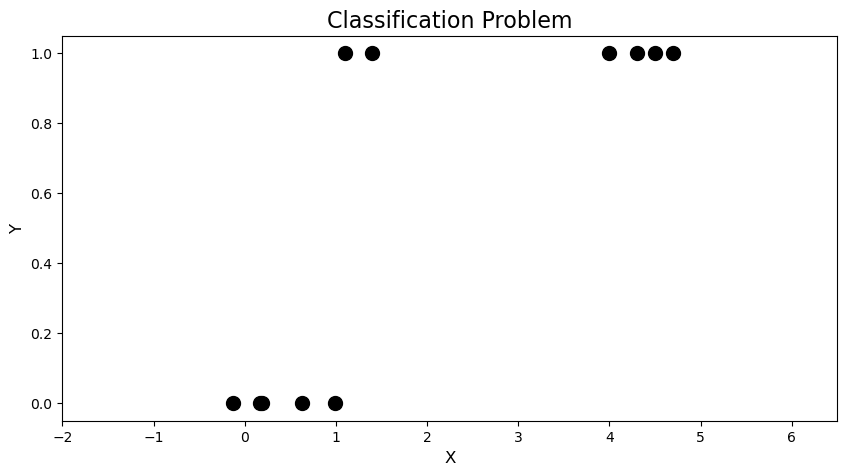

In [142]:
plt.figure(figsize=(10, 5))
plt.scatter(x,y,s=100,facecolors='k', edgecolors='k')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.title('Classification Problem', fontsize=16)
plt.xlim(left=-2, right=6.5)
plt.show()

In [143]:
g = least_squares; w = np.array([-1.0,-2.0])[:,np.newaxis]; max_its = 75; alpha_choice = 0.5;
weight_history,cost_history = newtons_method(g,max_its,w, data = x, labels = y, inputs_flag=True)

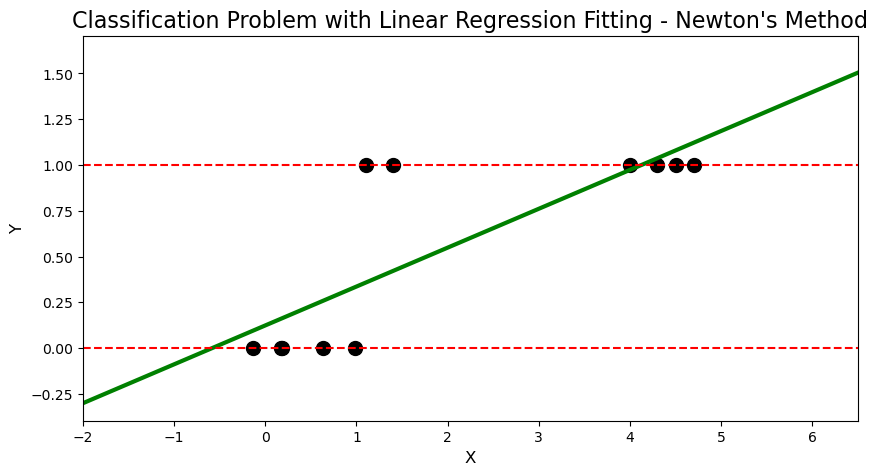

In [144]:
plt.figure(figsize=(10, 5))
plt.scatter(x,y,s=100,facecolors='k', edgecolors='k')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.title("Classification Problem with Linear Regression Fitting - Newton's Method", fontsize=16)
x_line = np.linspace(-2,7,1000).reshape((1,1000))
y_line = model_1(x_line,weight_history[-1])
plt.plot(x_line[0],y_line[0],'g-',linewidth=3)
plt.xlim(left=-2, right=6.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.axhline(y=1, color='r', linestyle='--')
plt.show()

### The logistic sigmoid function

- We cannot directly minimize the Least Squares above due to our use of the step function. 


- In other words, we cannot directly fit a *discontinuous* step function to our data. 


- In order to go further we need to replace the step, ideally with a *continuous* function that matches it very closely everywhere. 

- Thankfully such a function is readily available: the sigmoid function, $\sigma(\cdot)$

\begin{equation}
\sigma\left(x\right) = \frac{1}{1 + e^{-x}}.
\end{equation}


- This kind of function is alternatively called a *logistic* or *logistic sigmoid* function.


- When we fit such a function to a classification dataset we are therefore performing regression with a logistic or *logistic regression*.

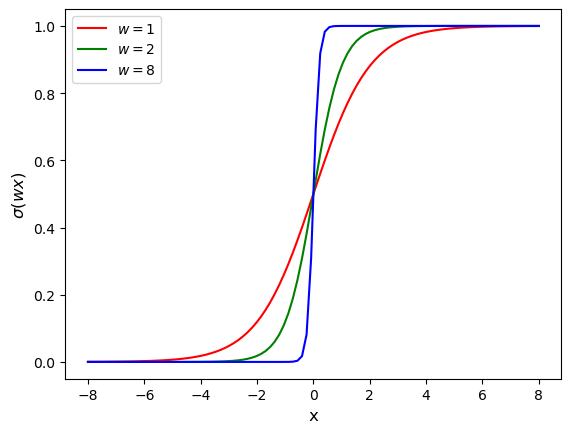

In [145]:
x1 = np.linspace(-8, 8, 100)
z1 = 1/(1 + np.exp(-1*x1))
x2 = np.linspace(-8, 8, 100)
z2 = 1/(1 + np.exp(-2*x2))
x3 = np.linspace(-8, 8, 100)
z3 = 1/(1 + np.exp(-10*x3))
plt.plot(x1, z1, 'r-', label = r'$w=1$')
plt.plot(x2, z2, 'g-', label = r'$w=2$')
plt.plot(x3, z3, 'b-', label = r'$w=8$')
plt.xlabel("x", fontsize=12)
plt.ylabel(r"$\sigma(wx)$", fontsize=12)
plt.legend()
plt.show()

### Least Square Cost

- Swapping out the step function with the sigmoid we aim to satisfy as many of the $P$ equations that follow hold

\begin{equation}
\sigma\left(\mathring{\mathbf{x}}_{\,}^T\mathbf{w}^{\,}\right) = y_p \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, p=1,..,P
\end{equation}



- To *learn* parameters that force these approximations to hold we can do precisely what we did in the case of linear regression


- We can try to minimize the e.g., the squared error between both sides constructing the Least Squares point-wise cost

\begin{equation}
g_p\left(\mathbf{w}\right) = \left(\sigma\left(\mathring{\mathbf{x}}_{p}^T\mathbf{w}^{\,}\right) - y_p \right)^2 \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, p=1,..,P.
\end{equation}

- Taking the average of these squared errors gives a Least Squares cost for *logistic regression*

\begin{equation}
g\left(\mathbf{w}\right) = \frac{1}{P}\sum_{p=1}^P \left(\sigma\left(\mathring{\mathbf{x}}_{\,}^T\mathbf{w}^{\,} \right) - y_p \right)^2
\end{equation}


- This function - an example of which is plotted above in the middle panel - is generally non-convex and contains large flat regions.  


- This can make it difficult, but not impossible, to minimize properly using some local methods (e.g., standard gradient descent and Newton's method).

In [146]:
def sigmoid(t):
    return 1/(1 + np.exp(-t))

# sigmoid non-convex logistic least squares cost function
def sigmoid_least_squares(w,x,y):
    a = w[0] + np.dot(x.T,w[1:])
    predictions = np.array([sigmoid(l) for l in a]).T
    cost = sum((predictions.flatten()-y.flatten())**2)
    return cost/y.size

In [147]:
x = data[:-1,:] # up to last row (exclusive) of data & all columns
y = data[-1:,:] # last row of data & all columns

In [148]:
#w_hist = gradient_descent(g = sigmoid_least_squares,w = w,version = 'normalized',max_its = 900, alpha = 1)
g = sigmoid_least_squares; w = np.asarray([10.0,-5.0])[:,np.newaxis]; max_its = 10000; alpha_choice = 1; #w = np.asarray([10.0,-5])[:,np.newaxis]
#weight_history,cost_history = gradient_descent(g,alpha_choice,max_its,w, data = x, labels = y, inputs_flag=True)
weight_history = normalized_gradient_descent(g, alpha = alpha_choice, max_its = max_its, w = w, data=x, labels=y, inputs_flag = True)

In [149]:
def model_classification_01(x_p,w):
    # compute linear combination and return
    a = w[0] + np.dot(x_p.T,w[1:])
    predictions = [sigmoid(l) for l in a]
    return predictions

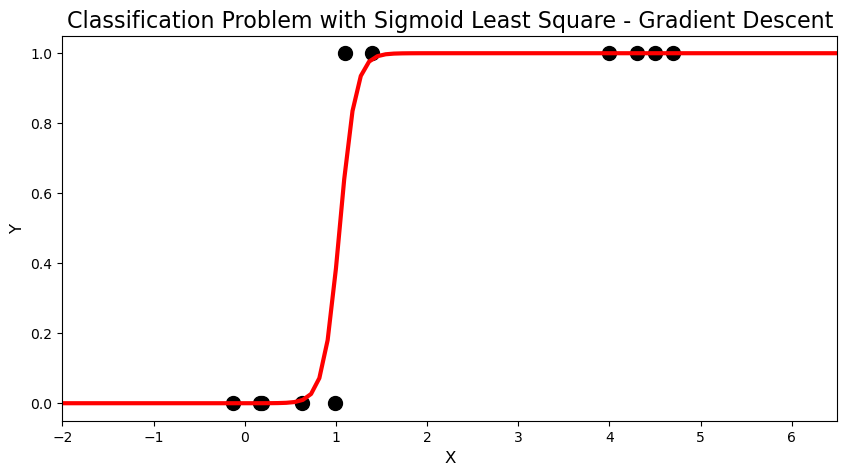

In [150]:
plt.figure(figsize=(10, 5))
plt.scatter(x,y,s=100,facecolors='k', edgecolors='k')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.title("Classification Problem with Sigmoid Least Square - Gradient Descent", fontsize=16)
x_line = np.linspace(-2,7,100).reshape((1,100))
y_line = model_classification_01(x_line,weight_history[-1])
plt.plot(x_line[0],y_line,'r-',linewidth=3)
plt.xlim(left=-2, right=6.5)
plt.show()

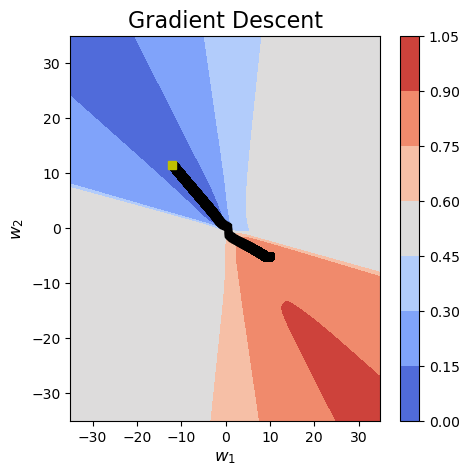

In [151]:
plot_contours(g, weight_history, title = 'Gradient Descent', data = x, labels = y, a = -35, b=35, inputs_flag=True)

### Logistic regression using the Cross Entropy cost

- There is more than one way to form a cost function whose minimum forces as many of the $P$ equalities to hold as well as possible.  


- The squared error / point-wise cost $g_p\left(\mathbf{w}\right) = \left(\sigma\left(\mathring{\mathbf{x}}_{p}^T\mathbf{w}^{\,} \right) - y_p\right)^2$ penalty works universally, regardless of the values taken by the output by $y_p$.  


- However because we *know* that the output we deal with now is limited to the *discrete* values $y_p \in \left\{0,1\right\}$ it is reasonable to ask if we cannot create a more appropriate cost that is customized to deal with just such output.

- Such a point-wise cost does exist for these restricted output values.  


- One such cost - which we call the *Log Error* - is as follows

\begin{equation}
g_p\left(\mathbf{w}\right)=
\begin{cases}
-\text{log}\left(\sigma\left( \mathring{\mathbf{x}}_{p}^T\mathbf{w}^{\,} \right) \right) \,\,\,\,\,\,\,\,\,\,  \,\,\,\,  \text{if} \,\, y_p = 1 \\
-\text{log}\left(1 - \sigma\left( \mathring{\mathbf{x}}_{p}^T\mathbf{w}^{\,} \right) \right) \,\,\,\,\,\text{if} \,\, y_p = 0. \\
\end{cases}
\end{equation}

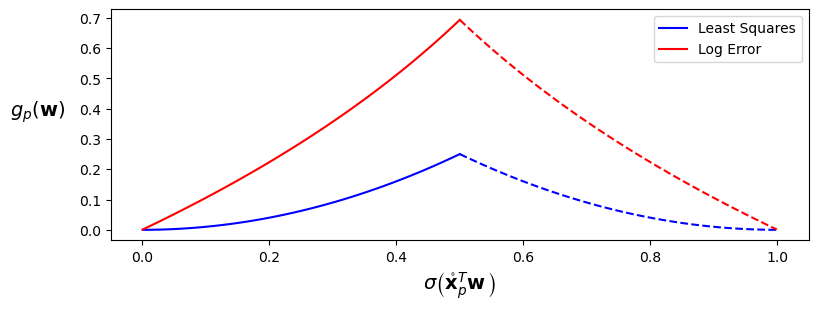

In [152]:
# setup figure
fig = plt.figure(figsize = (9,3))

# plot the per point cost when label = 1  
y_label = 1
alpha = np.linspace(0.5,.999,100)

least_squares = (y_label-alpha)**2
plt.plot(alpha, least_squares, 'b--')

log_error = -np.log(alpha)
plt.plot(alpha, log_error, 'r--')

# plot the per point cost when label = 0
y_label = 0
alpha = np.linspace(0.001,.5,100)

least_squares = (y_label-alpha)**2
plt.plot(alpha, least_squares, color='b', label='Least Squares')

log_error = -np.log(1-alpha)
plt.plot(alpha, log_error, color='r', label='Log Error')

# plot
plt.legend()
plt.xlabel(r'$\sigma\left(  \mathring{\mathbf{x}}_{p}^T\mathbf{w}^{\,}    \right)$',fontsize=14)
plt.ylabel(r'$g_p\left(\mathbf{w}\right)$', fontsize=14, rotation=0, labelpad=30)
plt.show()

Log-error cost penalizes violations of the decision much more harshly than a squared error does

- Suppose we have our *optimally tuned our weights* and that $y_p = 1$.  


- Then with our ideal weights we should satisfy our desired equality and have $\sigma\left(\mathring{\mathbf{x}}_{\,}^T\mathbf{w}^{\,}\right)  \approx y_p = 1$, and if this indeed the case then $-\text{log}\left(\sigma\left(\mathring{\mathbf{x}}_{\,}^T\mathbf{w}^{\,}\right) \right) \approx  -\text{log}\left(1\right) = 0$ which is a neglibable penalty.  


- However if $\sigma\left(\mathring{\mathbf{x}}_{\,}^T\mathbf{w}^{\,}\right)  < 1$ the value $-\text{log}\left(\sigma\left(\mathring{\mathbf{x}}_{\,}^T\mathbf{w}^{\,}\right) \right)$ *becomes large and positive very quickly harshly penalizing violations of our desired equality*.  


- As $\sigma\left(\mathring{\mathbf{x}}_{\,}^T\mathbf{w}^{\,}\right) $ approaches $0$ - the worst possible value it could take on if indeed $y_p = 1$ - then cost value goes to *positive infinity*. 


- So indeed, this point-wise cost function penalizes violations when $y_p = 1$ very strictly and is minimal (equals $0$) in value when the desired equality holds.  


- Precisely the same thing can be said when $y_p = 0$, that this point-wise cost takes on a minimal value when $\sigma\left(\mathring{\mathbf{x}}_{\,}^T\mathbf{w}^{\,}\right)  \approx 0$ and is very large otherwise going to positive infinity as $\sigma\left(\mathring{\mathbf{x}}_{\,}^T\mathbf{w}^{\,}\right) $ approaches the worst possible value of $1$.  


- So - in short - point-wise cost severely punishes violations of our desired equalitiesa and takes on a minimum value of $0$ when our weights $\mathbf{w}$ are properly tuned i.e.,

\begin{equation}
g_p\left(\mathbf{w}\right)\approx 0.
\end{equation}

- We can then form the so-called *Cross Entropy* cost function by taking the average of the Log Error costs over all $P$ points as

\begin{equation}
g\left(\mathbf{w}\right) = \frac{1}{P}\sum_{p=1}^P g_p\left(\mathbf{w}\right). 
\end{equation}


- Finally notice that we can write the Log Error equivalently - combining the two cases -  in a single line as

\begin{equation}
g_p\left(\mathbf{w}\right)=
-y_p\,\text{log}\left(\sigma\left(\mathring{\mathbf{x}}_{p}^T\mathbf{w}^{\,}\right) \right) 
-\left(1-y_p\right)\text{log}\left(1 -\sigma\left(\mathring{\mathbf{x}}_{p}^T\mathbf{w}^{\,}\right) \right).
\end{equation}

- We can form the same cost function as above by taking the average of this form of the Log Error giving


\begin{equation}
g\left(\mathbf{w}\right) = \frac{1}{P}\sum_{p=1}^P g_p\left(\mathbf{w}\right) \\= - \frac{1}{P}\sum_{p=1}^P y_p\,\text{log}\left(\sigma\left(\mathring{\mathbf{x}}_{p}^T\mathbf{w}^{\,}\right) \right) 
+\left(1-y_p\right)\text{log}\left(1 - \sigma\left(\mathring{\mathbf{x}}_{p}^T\mathbf{w}^{\,}\right) \right)
\end{equation}


- This is the more common way of expressing the Cross Entropy cost.

- In any case, to recover the *ideal* weights that make the formulae in equation (4) hold as tightly as possible we want to *minimize* this cost over $\mathbf{w}$.   


- In other words, to optimally tune the parameters $\mathbf{w}$ we want to *minimize* the Cross Entropy cost as 

$$
\underset{\mathbf{w}}{\text{argmin}}\,\, -\frac{1}{P}\sum_{p=1}^P  y_p\,\text{log}\left(\sigma\left(\mathring{\mathbf{x}}_{p}^{T}\mathbf{w}^{\,}\right)\right) + \left(1 - y_p\right)\text{log}\left(1 - \sigma\left(\mathring{\mathbf{x}}_{p}^{T}\mathbf{w}^{\,}\right)\right) 
$$

- The Cross Entropy cost is *always convex* regardless of the dataset used.

- Since the Cross Entropy cost function is convex a variety of local optimization schemes can be more easily used to properly minimize it.  


- For this reason the Cross Entropy cost is used more often in practice for logistic regression than is the logistic Least Squares cost.

- Our linear `model` takes in both an appended input point $\mathring{\mathbf{x}}_p$ and a set of weights $\mathbf{w}$ 

\begin{equation}
\text{model}\left(\mathbf{x}_p,\mathbf{w}\right) = \mathring{\mathbf{x}}_{p}^{T}\mathbf{w}^{\,}.
\end{equation}


- With this notation for our model, the corresponding Cross Entropy cost in equation (16) can be written as

\begin{equation*}
g(\mathbf{w}) = -\frac{1}{P}\sum_{p=1}^P  y_p\text{log}\left(\sigma\left(\text{model}\left(\mathbf{x}_p,\mathbf{w}\right)\right)\right) + \left(1 - y_p\right)\text{log}\left(1 - \sigma\left(\text{model}\left(\mathbf{x}_p,\mathbf{w}\right)\right)\right) 
\end{equation*}

In [153]:
# compute linear combination of input point
def model_2(x,w):
    a = w[0] + np.dot(x.T,w[1:])
    return a.T

In [154]:
# define sigmoid function
def sigmoid(t):
    return 1/(1 + np.exp(-t))

# the convex cross-entropy cost function
def cross_entropy(w,x,y):
    # compute sigmoid of model
    a = sigmoid(model_2(x,w))
    # compute cost of label 0 points
    ind = np.argwhere(y == 0)[:,1]
    cost = -np.sum(np.log(1 - a[:,ind]))
    
    # add cost on label 1 points
    ind = np.argwhere(y==1)[:,1]
    cost -= np.sum(np.log(a[:,ind]))
    
    # compute cross-entropy
    return cost/y.size

In [155]:
g = cross_entropy; w = np.array([3.0,3.0])[:,np.newaxis]; max_its = 1000; alpha_choice = 10**(0);
weight_history,cost_history = gradient_descent(g,alpha_choice,max_its,w, data = x, labels = y, inputs_flag=True)

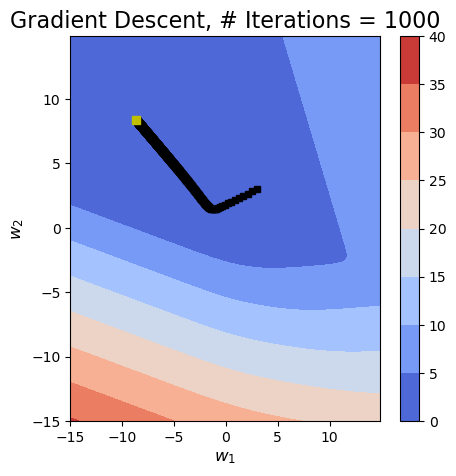

In [156]:
plot_contours(g, weight_history, title = 'Gradient Descent, # Iterations = {}'.format(max_its), data = x, labels = y, a = -15, b=15, inputs_flag=True)

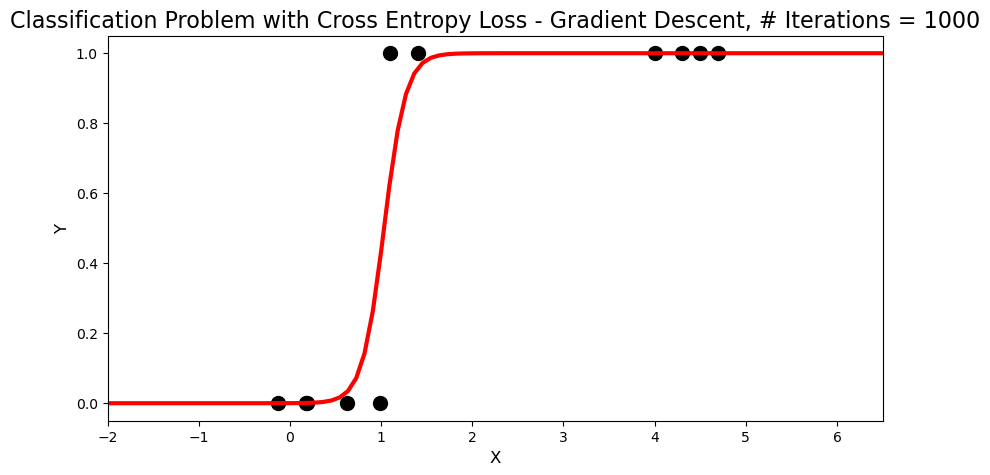

In [157]:
plt.figure(figsize=(10, 5))
plt.scatter(x,y,s=100,facecolors='k', edgecolors='k')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.title("Classification Problem with Cross Entropy Loss - Gradient Descent, # Iterations = {}".format(max_its), fontsize=16)
x_line = np.linspace(-2,7,100).reshape((1,100))
y_line = model_classification_01(x_line,weight_history[-1])
plt.plot(x_line[0],y_line,'r-',linewidth=3)
plt.xlim(left=-2, right=6.5)
plt.show()

In [158]:
g = cross_entropy; w = np.array([3.0,3.0])[:,np.newaxis]; max_its = 2000; alpha_choice = 10**(0);
weight_history,cost_history = gradient_descent(g,alpha_choice,max_its,w, data = x, labels = y, inputs_flag=True)

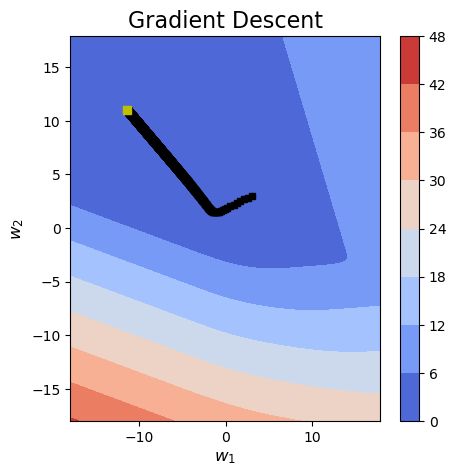

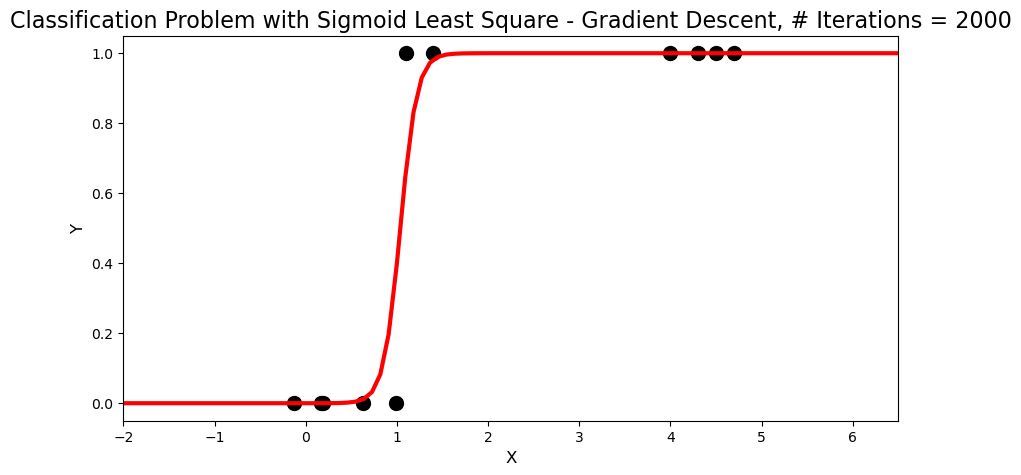

In [159]:
plot_contours(g, weight_history, title = 'Gradient Descent', data = x, labels = y, a = -18, b=18, inputs_flag=True)
plt.figure(figsize=(10, 5))
plt.scatter(x,y,s=100,facecolors='k', edgecolors='k')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.title("Classification Problem with Sigmoid Least Square - Gradient Descent, # Iterations = {}".format(max_its), fontsize=16)
x_line = np.linspace(-2,7,100).reshape((1,100))
y_line = model_classification_01(x_line,weight_history[-1])
plt.plot(x_line[0],y_line,'r-',linewidth=3)
plt.xlim(left=-2, right=6.5)
plt.show()

### Logistic regression using the Softmax cost

 - Assuming $y_p \in \left\{-1,+1\right\}$

- Re-arranging the hyperbolic tangent function in terms of the sigmoid we have:


\begin{equation}
\sigma\left(x\right) = \frac{\text{tanh}(x) + 1}{2}.
\end{equation}

- $tanh$ ranges smoothly between $-1$ and $1$

- The cost function in this case is:

\begin{equation}
g(\mathbf{w}) = \frac{1}{P}\sum_{p=1}^P \left(tanh\left( \mathring{\mathbf{x}}_{p}^T\mathbf{w}^{\,} \right)-y_p\right)^2
\end{equation}

- The above function is nonconvex with undesirable flat regions, requiring specialized local methods for its proper minimization

- Because $y_p \in \left\{-1,+1\right\}$ here we can construct a new cost function based on a penalty that more harshly penalizes error.  

\begin{equation}
g_{p}\left(\mathbf{w}\right)=
\begin{cases}
-\text{log}\left(\sigma\left( \mathring{\mathbf{x}}_{p}^T\mathbf{w}^{\,} \right) \right) \,\,\,\,\,\,\,\,\,\,  \,\,\,\,  \text{if} \,\, y_p = +1 \\
-\text{log}\left(1 - \sigma\left( \mathring{\mathbf{x}}_{p}^T\mathbf{w}^{\,} \right) \right) \,\,\,\,\,\text{if} \,\, y_p = -1. \\
\end{cases}
\end{equation}

- We can then form the *Softmax* cost for logistic regression by taking an average of these Log Error costs as 


\begin{equation}
g\left(\mathbf{w}\right) = \frac{1}{P}\sum_{p=1}^P g_p\left(\mathbf{w}\right). 
\end{equation}


- As with the Cross Entropy cost it is far more common to express the Softmax cost differently by re-writing the Log Error in a equivalent way as follows. 

 - First notice that because 


\begin{equation}
1 - \sigma\left(x\right) = 1 - \frac{1}{1 + e^{-x}} = \frac{1}{1 + e^{x}} = \sigma(-x)
\end{equation}


- The second case in the point-wise cost above can be re-written equivalently as $-\text{log}\left(\sigma\left( - \mathring{\mathbf{x}}_{\,}^T\mathbf{w}^{\,} \right)\right)$ and so the point-wise cost function can be written as


\begin{equation}
g_{p}\left(\mathbf{w}\right)=
\begin{cases}
-\text{log}\left(\sigma\left( \mathring{\mathbf{x}}_{p}^T\mathbf{w}^{\,} \right) \right) \,\,\,\,\,\,\,\, \,  \text{if} \,\, y_p = +1 \\
-\text{log}\left(\sigma\left( -\mathring{\mathbf{x}}_{p}^T\mathbf{w}^{\,} \right) \right) \,\,\,\,\,\text{if} \,\, y_p = -1. \\
\end{cases}
\end{equation}

- Now notice that *because we are using the label values $\pm 1$* we can move the label value in each case *inside* the inner most paraenthesis, and we can write *both cases* in a single line as 


\begin{equation}
g_p\left(\mathbf{w}\right)=
-\text{log}\left(\sigma\left( y_p\,\mathring{\mathbf{x}}_{p}^T\mathbf{w}^{\,} \right) \right).
\end{equation}


- Finally since the negative log property states that $-\text{log}\left(x\right) = \frac{1}{x}$ we can re-write the point-wise cost above equivalently (using the definition of the sigmoid) as 


$$
g_p\left(\mathbf{w}\right)=
\text{log}\left(1 + e^{-\overset{\,}{y}_p^{\,}\mathring{\mathbf{x}}_{p}^{T}\mathbf{w}^{\,}}\right)$$

- Taking the average of this point-wise cost over all $P$ points we have a more common appearance of the *Softmax cost for logistic regression*

\begin{equation}
g(\mathbf{w}) = \frac{1}{P}\sum_{p=1}^P g_p\left(\mathbf{w}\right) = \frac{1}{P}\sum_{p=1}^P\text{log}\left(1 + e^{-\overset{\,}{y}_p^{\,}\mathring{\mathbf{x}}_{p}^{T}\mathbf{w}^{\,}}\right)
\end{equation}


- This cost function, like the Cross Entropy cost detailed in the previous Section, is *always convex regardless of the dataset used*.

- Moreover, as we can see here by its derivation, the Softmax and Cross Entropy cost functions are completely equivalent (upon change of label value $y_p = -1$ to $y_p = 0$ and vice-versa) having been built using the same point-wise cost function. 

- The Softmax cost is *always convex* regardless of the dataset used.

In [160]:
y_softmax = copy.deepcopy(y)

In [161]:
y_softmax[y_softmax==0] = -1

In [162]:
# compute linear combination of input point
def model_3(x,w):
    a = w[0] + np.dot(x.T,w[1:])
    return a.T

In [163]:
# define sigmoid function
def sigmoid(t):
    return 1/(1 + np.exp(-t))

# the convex softmax cost function
def softmax(w,x,y):
    cost = np.sum(np.log(1 + np.exp(-y*model_3(x,w))))
    return cost/float(np.size(y))

In [164]:
g = softmax; w = np.array([3.0,3.0])[:,np.newaxis]; max_its = 2000; alpha_choice = 1;
weight_history,cost_history = gradient_descent(g,alpha_choice,max_its,w, data = x, labels = y_softmax, inputs_flag=True)

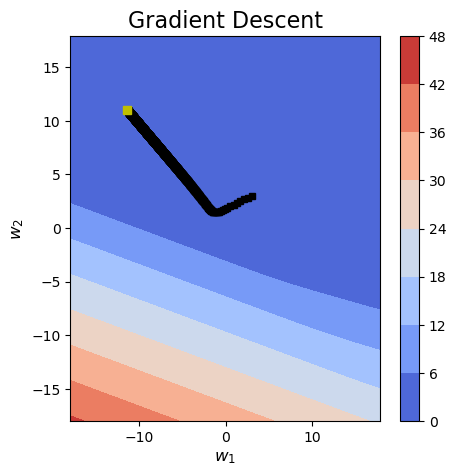

In [165]:
plot_contours(g, weight_history, title = 'Gradient Descent', data = x, labels = y, a = -18, b=18, inputs_flag=True)

In [166]:
def model_classification_NegativePositiveLabel(x_p,w):
    # compute linear combination and return
    a = w[0] + np.dot(x_p.T,w[1:])
    predictions = [2*sigmoid(l)-1 for l in a]
    return predictions

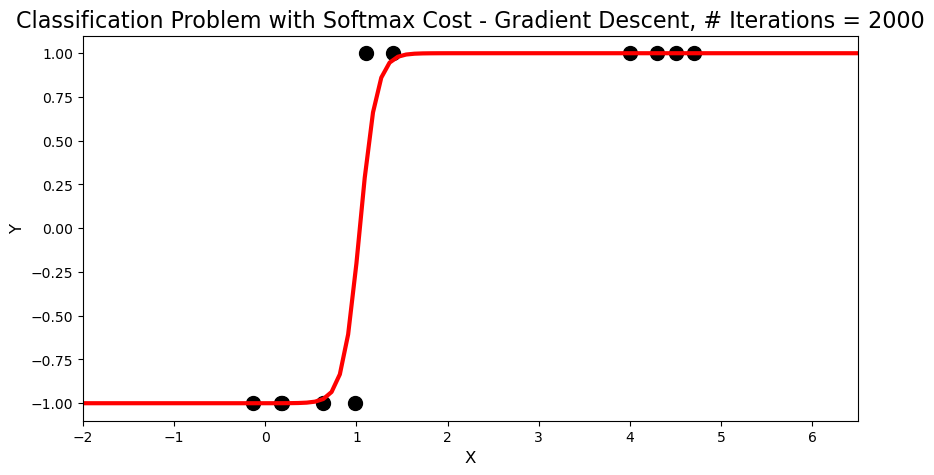

In [167]:
plt.figure(figsize=(10, 5))
plt.scatter(x,y_softmax,s=100,facecolors='k', edgecolors='k')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.title("Classification Problem with Softmax Cost - Gradient Descent, # Iterations = {}".format(max_its), fontsize=16)
x_line = np.linspace(-2,7,100).reshape((1,100))
y_line = model_classification_NegativePositiveLabel(x_line,weight_history[-1])
plt.plot(x_line[0],y_line,'r-',linewidth=3)
plt.xlim(left=-2, right=6.5)
plt.show()

## Noisy Dataset

- Below we show a multi-input ($N = 2$) dataset of 100 points.


- Here the two classes cannot be perfectly separated by any line.

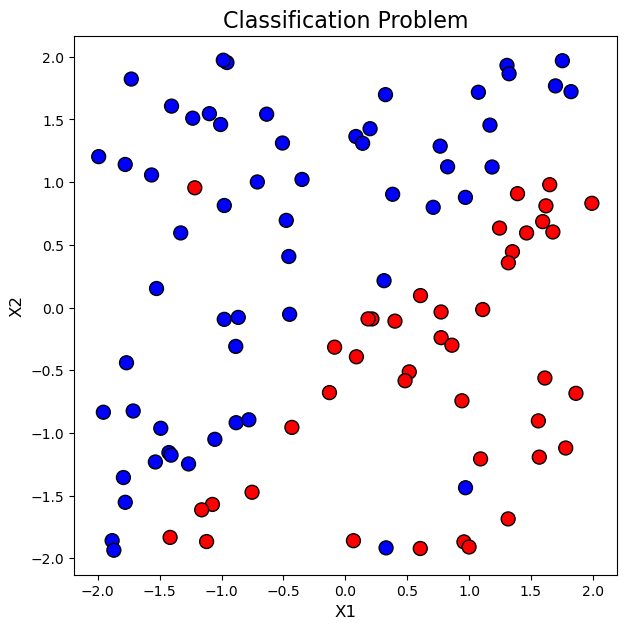

In [168]:
data = np.loadtxt(readDataPath + '3d_classification_data_v0.csv',delimiter = ',')
data_plot = copy.deepcopy(data)
data_plot = pd.DataFrame(data_plot)
data_plot = data_plot.T
data_plot.columns=["X1", "X2", "Y"]
col = np.where(data_plot["Y"]==1,'r','b')
plt.figure(figsize=(7, 7))
plt.scatter(data_plot["X1"],data_plot["X2"],s=100,c=col, edgecolors='k')
plt.xlabel('X1', fontsize = 12)
plt.ylabel('X2', fontsize = 12)
plt.title('Classification Problem', fontsize=16)
plt.show()

In [169]:
#np.random.seed(0)
x = data[:-1,:]
y = data[-1:,:] 
# run gradient descent to minimize the softmax cost
g = softmax; w = np.random.randn(3,1); max_its = 20000; alpha_choice = 1;
weight_history,cost_history = gradient_descent(g,alpha_choice,max_its,w, data = x, labels = y, inputs_flag=True)

In [170]:
x_contour = np.arange(-3, 3, 0.01)
y_contour = np.arange(-3, 3, 0.01)
xx, yy = np.meshgrid(x_contour, y_contour)
X_pred = np.c_[xx.ravel(), yy.ravel()]

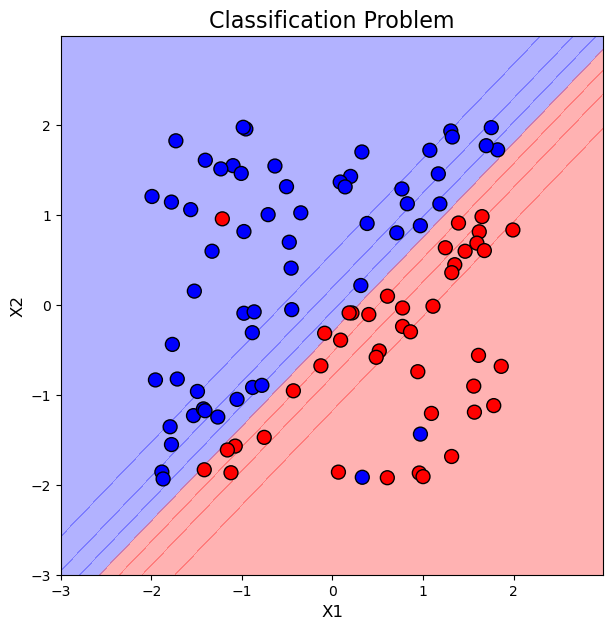

In [171]:
from matplotlib import colors
#x_line = np.linspace(-2,2,(2,100))
#x_line = np.linspace((-2,-2),(2,2),100)
#x_line = x_line.T
y_line = np.asarray(model_classification_NegativePositiveLabel(X_pred.T,weight_history[-1]))
plt.figure(figsize=(7, 7))
contour_labels = y_line.reshape(xx.shape)
cmap = colors.ListedColormap(['blue', 'red'])
cs = plt.contourf(xx, yy, contour_labels, cmap=cmap, alpha=0.3, extent=[X_pred[0].min(), X_pred[0].max(), X_pred[1].min(), X_pred[1].max()])
#plt.plot(x_line[0],y_line,'r-',linewidth=3)
#plt.xlim(left=-2, right=6.5)
col = np.where(data_plot["Y"]==1,'r','b')
plt.scatter(data_plot["X1"],data_plot["X2"],s=100,c=col, edgecolors='k')
plt.xlabel('X1', fontsize = 12)
plt.ylabel('X2', fontsize = 12)
plt.title('Classification Problem', fontsize=16)
plt.show()

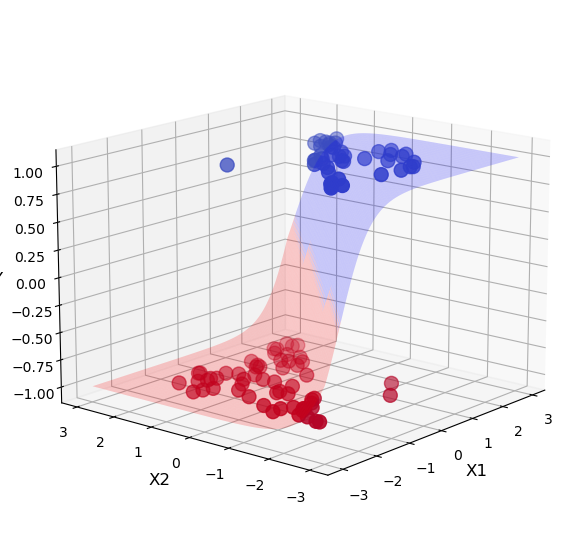

In [172]:
fig = plt.figure(figsize = (10, 7))
c = (data[2]<=0)
ax = plt.axes(projection ="3d")
my_cmap = plt.get_cmap('hsv')
ax.scatter3D(data[0], data[1], data[2], c = c, cmap = 'coolwarm', s=100)
#ax.view_init(10, 60)
ax.view_init(15, -140)
ax.set_xlabel('X1', fontsize=12)
ax.set_ylabel('X2', fontsize=12)
ax.set_zlabel('Y', fontsize=12)
cmap = colors.ListedColormap(['red', 'blue'])
ax.plot_surface(xx, yy, contour_labels, alpha=0.2, cmap = cmap)
plt.show()

# Perceptron

- As we have seen with logistic regression we treat classification as a particular form of nonlinear regression (employing - with the choice of label values $y_p \in \left\{-1,+1\right\}$ - a tanh nonlinearity). 


- This results in the learning of a proper nonlinear regressor, and a corresponding *linear decision boundary* 

\begin{equation}
\mathring{\mathbf{x}}_{\,}^{T}\mathbf{w}^{\,}=0.
\end{equation}

- Instead of learning this decision boundary as a result of a nonlinear regression, the *perceptron* derivation described here aims at determining this ideal lineary decision boundary directly.  


- While we will see how this direct approach leads back to the *Softmax cost function*, Practically speaking the perceptron and logistic regression *often results in learning the same linear decision boundary*, the perceptron's focus on learning the decision boundary directly provides a valuable new perspective on the process of two-class classification.  

## The Perceptron cost function

- The linear decision boundary cuts the input space into two half-planes: 
\begin{equation}
\mathring{\mathbf{x}}_{\,}^{T}\mathbf{w}^{\,}>0 \quad \text{if} \quad y_p = +1
\end{equation}

\begin{equation}
\mathring{\mathbf{x}}_{\,}^{T}\mathbf{w}^{\,}<0 \quad \text{if} \quad y_p = -1
\end{equation}


- Because of our choice of label values we can consolidate the ideal conditions above into the single equation below:
\begin{equation}
-y_p\mathring{\mathbf{x}}_{\,}^{T}\mathbf{w}^{\,}<0
\end{equation}


- By taking the maximum of this quantity and zero, we can write this ideal condition, which states that a hyperplance correctly classifies a point, equivalently forming a point-wise cost:
\begin{equation}
g_p(\mathbf{w}) = max(0,-y_p\mathring{\mathbf{x}}_{\,}^{T}\mathbf{w}^{\,})
\end{equation}

- This expression is always non-negative, since it returns zero if $\mathbf{x}_p$ is classified correctly, and returns a positive value if the point is classified incorrectly. The functional form of this point-wise cost $max(0,\cdot)$ is often called a rectified linear unit (ReLU).

- Taking the average over the entire dataset to form a proper cost function as:
\begin{equation}
g_p(\mathbf{w}) = \frac{1}{P}\sum_{p=1}^{P}max(0,-y_p\mathring{\mathbf{x}}_{\,}^{T}\mathbf{w}^{\,})
\end{equation}

- When minimized appropriately, this cost function can be used to recover the ideal weights satisfying the desired equations above as often as possible

## The smooth softmax approximation to the ReLU cost

- Learning and optimization go hand in hand, and as we know from the discussion above the ReLU function limits the number of optimization tools we can bring to bear for learning. 


- Here we describe a common approach to ameliorating this issue by introducing a smooth approximation to this cost function. 


- If the approximation closely matches the true cost function then for the small amount of accuracy (we will after all be minimizing the approximation, not the true function itself) we significantly broaden the set of optimization tools we can use.

- One popular way of doing this for the ReLU cost function is via the *softmax* function defined as

\begin{equation}
\text{soft}\left(s_0,s_1,...,s_{C-1}\right) = \text{log}\left(e^{s_0} + e^{s_1} + \cdots + e^{s_{C-1}} \right)
\end{equation}


- Here $s_0,\,s_1,\,...,s_{C-1}$ are any $C$ scalar vaules - which is a generic smooth approximation to the *max* function, i.e., 


\begin{equation}
\text{soft}\left(s_0,s_1,...,s_{C-1}\right) \approx \text{max}\left(s_0,s_1,...,s_{C-1}\right)
\end{equation}

- Replace the $p^{th}$ summand of our ReLU cost with its softmax approximation

\begin{equation}
g_p\left(\mathbf{w}\right) = \text{soft}\left(0,-\overset{\,}{y}_{p}\mathring{\mathbf{x}}_{p}^T\mathbf{w}^{\,}\right) = \text{log}\left(1 + e^{-\overset{\,}{y}_{p}\mathring{\mathbf{x}}_{p}^T\mathbf{w}^{\,}}\right)
\end{equation}


- The overall cost function is then: $g\left(\mathbf{w}\right)=\sum_{p=1}^P g_p\left(\mathbf{w}\right) = \underset{p=1}{\overset{P}{\sum}}\text{log}\left(1 + e^{-\overset{\,}{y}_{p}\mathring{\mathbf{x}}_{p}^T\mathbf{w}^{\,}}\right)$


- This is the *Softmax cost* we saw previously derived from the logistic regression perspective.

- This is why the cost is called *Softmax*, since it derives from the general softmax approximation to the max function.


- Note that *like* the ReLU cost - as we already know - the Softmax cost is convex. 


- However *unlike* the ReLU cost, the softmax has infinitely many derivatives and Newton's method can therefore be used to minimize it. 


- Moreover, softmax does not have a trivial solution at zero like the ReLU cost does. 

- Nonetheless, the fact that the Softmax cost so closely approximates the ReLU shows just how closely aligned both logistic regression and the perceptron truly are. 


- Practically speaking their differences lie in how well - for a particular dataset - one can optimize either one, along with (what is very often slight) differences in the quality of each cost function's learned decision boundary.  


- Of course when the Softmax is employed from the perceptron perspective there is no qualitative difference between the perceptron and logistic regression at all.